In [12]:
import cv2
import numpy as np
import math
import os
from skimage import data
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.signal import savgol_filter
import json

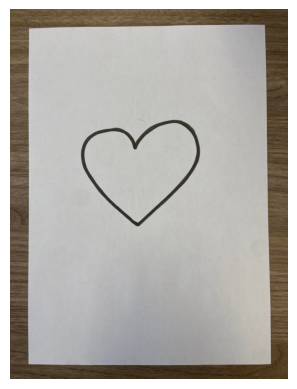

In [13]:
# Charger l'image
image = cv2.imread("shots/form_random1.png")
#image = cv2.imread("shots/form_random2.png")
#image = cv2.imread("shots/form_random3.png")
image = cv2.imread("shots/coeur.png")
##image = cv2.imread("shots/trait.png")
#image = cv2.imread("shots/trait_doigt.png")
#image = cv2.imread("shots/griboulli.png")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [14]:
"""# Chemin du dossier contenant les images
image_folder = "./shots"

# Récupérer tous les fichiers dans le dossier
image_files = os.listdir(image_folder)

# Trier la liste par date de modification (du plus récent au plus ancien)
image_files.sort(key=lambda x: os.path.getmtime(os.path.join(image_folder, x)), reverse=True)

# Charger la dernière image ajouter au dossier
latest_image_path = os.path.join(image_folder, image_files[0])
image = cv2.imread(latest_image_path)

# Afficher l'image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.show()"""

'# Chemin du dossier contenant les images\nimage_folder = "./shots"\n\n# Récupérer tous les fichiers dans le dossier\nimage_files = os.listdir(image_folder)\n\n# Trier la liste par date de modification (du plus récent au plus ancien)\nimage_files.sort(key=lambda x: os.path.getmtime(os.path.join(image_folder, x)), reverse=True)\n\n# Charger la dernière image ajouter au dossier\nlatest_image_path = os.path.join(image_folder, image_files[0])\nimage = cv2.imread(latest_image_path)\n\n# Afficher l\'image\nplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))\n#plt.axis(\'off\')\nplt.show()'

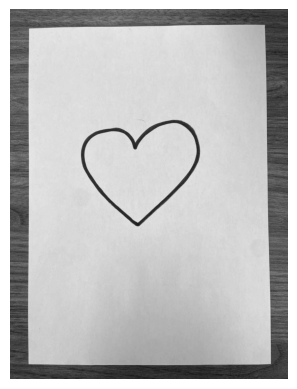

In [15]:
# Convertion de l'image en niveaux de gris
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray,'gray')
plt.axis('off')
plt.show()

4.0
549.0
641.0
720334.0


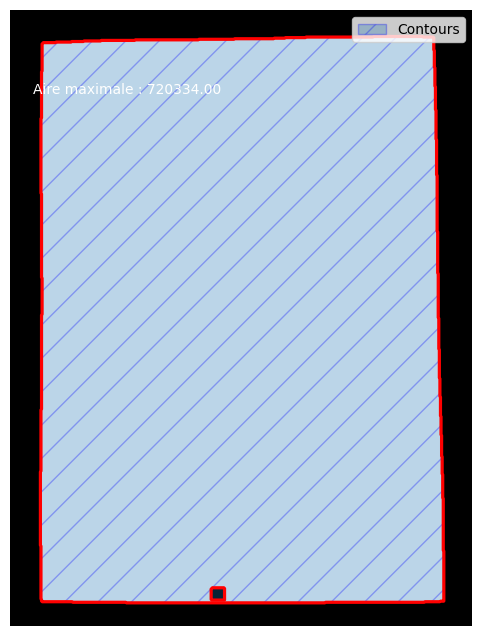

In [16]:
#Initialision des variables
valeur_seuil = 190
max_area = 0

#Recherche d'un seuillage qui permet de trouver la feuille A4
while max_area < 50000:
    # Binariser l'image
    _, thresh = cv2.threshold(gray, valeur_seuil, 255, cv2.THRESH_BINARY)

    # Appliquer un filtre morphologique pour enlever quelque imperfections
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Appliquer la détection de contours avec Canny
    edges = cv2.Canny(closing, 50, 255)

    # Trouver les contours externes
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Trouver le plus grand contour qui correspond à un quadrilatère quelconque

    best_cnt = None
    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)
        if len(approx) == 4 and area > max_area:
            max_area = area
            best_cnt = cnt
            print(max_area)
    valeur_seuil -= 2

# Vérifier si le contour trouvé est suffisamment grand pour être un bord de papier
if max_area > (closing.shape[0] * closing.shape[1]) / 4:
    # Hachurer la plus grande aire
    best_cnt = best_cnt.reshape(best_cnt.shape[0], 2)
    fig, ax = plt.subplots(figsize=(8, 8))

# Afficher l'image et les contours
ax.imshow(cv2.cvtColor(closing, cv2.COLOR_BGR2RGB))
ax.contour(edges, levels=[0], colors='red')
ax.fill(best_cnt[:, 0], best_cnt[:, 1], hatch='/', alpha=0.3, edgecolor='blue')
ax.text(40, 150, f'Aire maximale : {max_area:.2f}', color='white')
ax.legend(['Contours', 'Aire maximale'], loc='upper right')
plt.axis('off')
plt.show()

In [17]:
# Approximer le contour de l'aire hachurée en un polygone plus simple
epsilon = 0.05 * cv2.arcLength(best_cnt, True)
approx = cv2.approxPolyDP(best_cnt, epsilon, True)

# Trier les sommets du polygone en fonction de leur position
sorted_pts = sorted(approx, key=lambda x: x[0][0])

# Déterminer les coins haut gauche, haut droit, bas gauche, bas droit
top_left, bottom_left = sorted(sorted_pts[:2], key=lambda x: x[0][1])
top_right, bottom_right = sorted(sorted_pts[2:], key=lambda x: x[0][1])

# Afficher les coordonnées des coins initiaux
print("Coordonnées des coins initiaux :")
print(f"coin 1 : {tuple(top_left[0])}")
print(f"coin 2 : {tuple(top_right[0])}")
print(f"coin 3 : {tuple(bottom_left[0])}")
print(f"coin 4 : {tuple(bottom_right[0])}")

# Appliquer la marge alpha aux coins
alpha = -15
top_left += alpha * np.array([-1, -1])
top_right += alpha * np.array([1, -1])
bottom_left += alpha * np.array([-1, 1])
bottom_right += alpha * np.array([1, 1])

# Afficher les coordonnées des coins resserrés
print("\nCoordonnées des coins resserrés :")
print(f"coin 1 : {tuple(top_left[0])}")
print(f"coin 2 : {tuple(top_right[0])}")
print(f"coin 3 : {tuple(bottom_left[0])}")
print(f"coin 4 : {tuple(bottom_right[0])}")

Coordonnées des coins initiaux :
coin 1 : (57, 60)
coin 2 : (758, 48)
coin 3 : (57, 1060)
coin 4 : (777, 1059)

Coordonnées des coins resserrés :
coin 1 : (72, 75)
coin 2 : (743, 63)
coin 3 : (72, 1045)
coin 4 : (762, 1044)


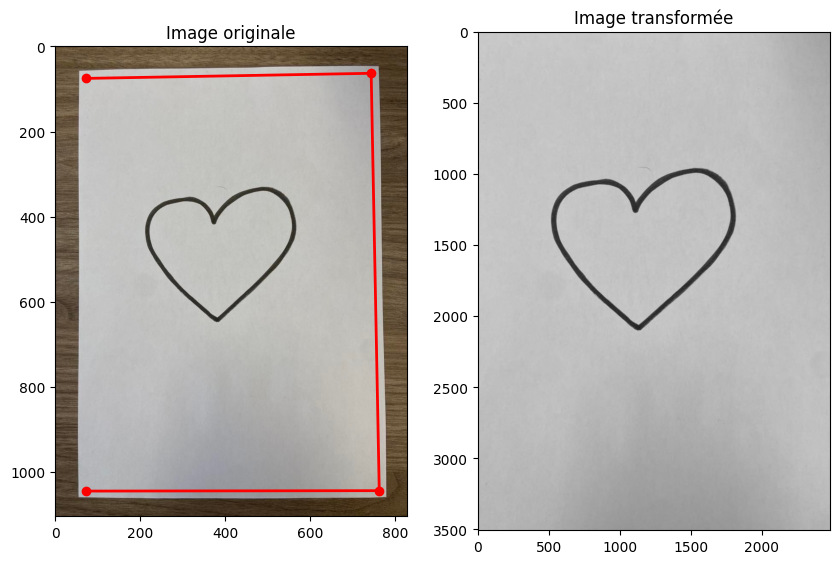

In [18]:
alpha = 30
# Définir les quatre coins du rectangle initial (en ordre : haut-gauche, haut-droit, bas-droit, bas-gauche)
rect = np.array([tuple(top_left[0]), tuple(top_right[0]), tuple(bottom_right[0]), tuple(bottom_left[0])])

# Calculer les longueurs des côtés opposés du rectangle
l1 = np.linalg.norm(top_right - top_left)
l2 = np.linalg.norm(top_right - bottom_right)

# Définir les dimensions de l'image de sortie (paysage ou portrait)
if l1 > l2:
    width = 3508
    height = 2480
else:
    width = 2480
    height = 3508

# Définir les quatre coins de l'image de sortie (en ordre : haut-gauche, haut-droit, bas-droit, bas-gauche)
dst = np.array([(0, 0), (width, 0), (width, height), (0, height)])

# Calculer la matrice de transformation
M = cv2.getPerspectiveTransform(rect.astype(np.float32), dst.astype(np.float32))

# Appliquer la transformation de perspective
warped = cv2.warpPerspective(gray, M, (width, height))

# Afficher l'image de départ et l'image transformée
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].plot(rect[:, 0], rect[:, 1], 'o-', color='red', linewidth=2)
axs[0].set_title('Image originale')
axs[1].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
axs[1].set_title('Image transformée')
plt.show()

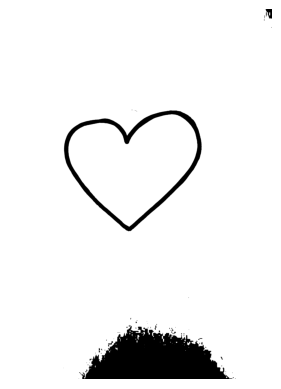

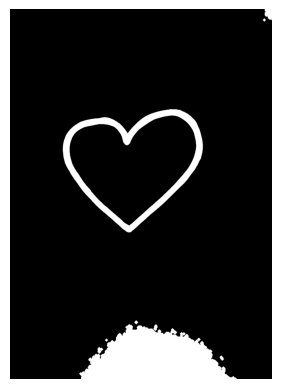

In [19]:
# Binariser l'image
_, thresh = cv2.threshold(warped, 163, 255, cv2.THRESH_BINARY)

plt.imshow(thresh,'gray')
plt.axis('off')
plt.show()

S = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
thresh = cv2.dilate(thresh, S, iterations = 3)

S = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
thresh = cv2.erode(thresh, S, iterations = 15)

thresh = np.invert(thresh)

plt.imshow(thresh,'gray')
plt.axis('off')
plt.show()

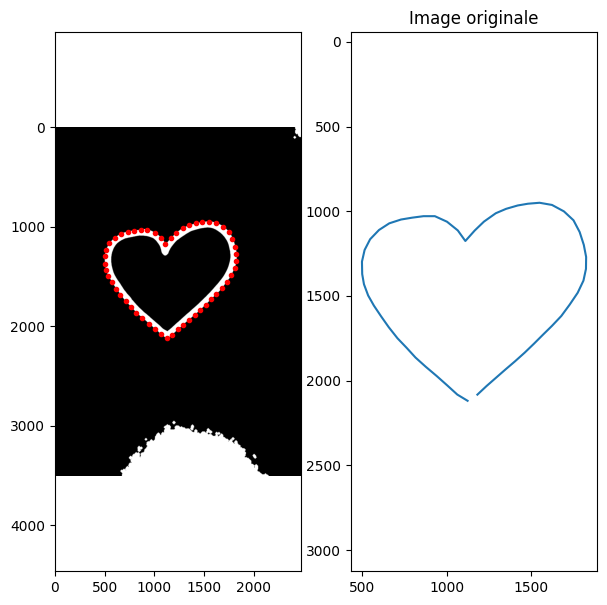

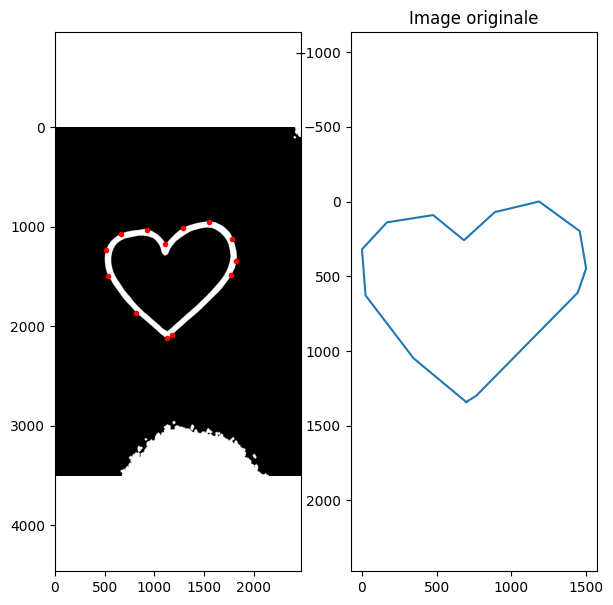

In [36]:
def rdp(points, epsilon):
    """ Implémentation de l'algorithme de Ramer-Douglas-Peucker pour simplifier une suite de points """
    dmax = 0
    index = 0
    end = len(points) - 1
    for i in range(1, end):
        d = distance_point_segment(points[i], points[0], points[end])
        if d > dmax:
            index = i
            dmax = d
    if dmax > epsilon:
        results1 = rdp(points[:index+1], epsilon)
        results2 = rdp(points[index:], epsilon)
        results1.extend(results2[1:])
        return results1
    else:
        return [points[0], points[end]]

def distance_point_segment(point, start, end):
    """ Calcul de la distance entre un point et un segment """
    if np.all(start == end):
        return np.linalg.norm(point - start)
    else:
        u = (point - start) / np.linalg.norm(end - start)
        proj = start + u * np.dot(end - start, u)
        if np.all(proj <= np.maximum(start, end)) and np.all(proj >= np.minimum(start, end)):
            return np.linalg.norm(proj - point)
        else:
            dist_start = np.linalg.norm(point - start)
            dist_end = np.linalg.norm(point - end)
            return min(dist_start, dist_end)

def get_trace(image):
    # Trouver le contour le plus long de l'image
    contours = find_contours(image, 0.5, fully_connected='low')
    contour = max(contours, key=len)
    
    # Ajouter un point supplémentaire si la longueur du contour est impaire
    if len(contour) % 2 == 1:
        contour = np.concatenate([contour, [contour[-1]]])
    
    # Extraire les coordonnées x et y des points du contour
    x = contour[:, 1]
    y = contour[:, 0]
    
    # Appliquer un filtre de Savitzky-Golay pour lisser le contour
    x_smoothed = savgol_filter(x, 9, 3)
    y_smoothed = savgol_filter(y, 9, 3)
    contour_smoothed = np.column_stack((y_smoothed, x_smoothed))
    
    contour_simplified = rdp(contour_smoothed, 0.5)
    nb_contour_points = len(contour_simplified)

    # Calculer le nombre de points en fonction de la longueur du contour
    nb_points = int(np.ceil(len(contour) / 101))


    # Calculer l'incrément pour sélectionner un nombre donné de points
    step = nb_contour_points / nb_points
    
    # Extraire les coordonnées x et y des points équidistants le long du contour
    x = []
    y = []
    for i in range(nb_points):
        index = int(i * step)
        point = contour_simplified[index]
        x.append(point[1])
        y.append(point[0])

    if len(contour) % 2 == 1:
        contour = np.concatenate([contour, [contour[-1]]])
        
    return x, y

def douglas_peucker(x, y, threshold): 
    points = np.column_stack((x, y))
    if len(points) < 3:
        return x, y
    dmax = 0
    index = 0
    end = len(points) - 1
    for i in range(1, end):
        d = np.linalg.norm(np.cross(points[i] - points[0], points[end] - points[0])) / np.linalg.norm(points[end] - points[0])
        if d > dmax:
            index = i
            dmax = d
    if dmax > threshold:
        left_x, left_y = douglas_peucker(x[:index+1], y[:index+1], threshold)
        right_x, right_y = douglas_peucker(x[index:], y[index:], threshold)
        return left_x[:-1] + right_x, left_y[:-1] + right_y
    else:
        return [x[0], x[end]], [y[0], y[end]]

# Extraire les listes x et y représentant le traçé de l'image
x, y = get_trace(thresh)

# Afficher les points sur l'image tresh
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
axs[0].imshow(thresh, cmap='gray')
axs[0].plot(x, y, 'r.',linewidth = 0.001)
axs[0].axis('equal')

#Affichage 2
axs[1].plot(x, y)
plt.ylim(max(y), min(y)) # inverse les limites de l'axe y
axs[1].axis('equal')
axs[1].set_title('Image originale')
plt.show()

x, y = douglas_peucker(x, y, 44) # 25 : il s'agit de la distance maximale perpendiculaire entre un point de la courbe originale et la courbe simplifiée.

# Afficher les points sur l'image tresh
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
axs[0].imshow(thresh, cmap='gray')
axs[0].plot(x, y, 'r.',linewidth = 0.001)
axs[0].axis('equal')

min_x = min(x)
min_y = min(y)

# Calcul du facteur de redimensionnement
factor = max(max(x) - min_x, max(y) - min_y) / 1500

# Redimensionnement des listes de points
x = [(x[i] - min_x) / factor for i in range(len(x))]
y = [(y[i] - min_y) / factor for i in range(len(y))]

x.append(x[0])
y.append(y[0])

# Afficher les résultats
#print("x : ", x)
#print("y : ", y)

# Afficher l'image de départ et l'image transformée
axs[1].plot(x, y)
plt.ylim(max(y), min(y)) # inverse les limites de l'axe y
axs[1].axis('equal')
axs[1].set_title('Image originale')
plt.show()

In [21]:
deltas = []
thetas_abs = []
thetas_rel = []

# On considère que le robot est initialement orienté vers le premier point
angle_robot = math.atan2(y[1]-y[0], x[1]-x[0])

for i in range(len(x)-1):
    # Récupérer les coordonnées des points successifs
    x1, y1 = x[i], y[i]
    x2, y2 = x[i+1], y[i+1]

    # Calculer la distance entre les points
    delta = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    deltas.append(delta)

    # Calculer l'angle absolu entre les points (en radians)
    angle_abs = math.atan2(y2-y1, x2-x1)
    thetas_abs.append(angle_abs)

    # Calculer l'angle relatif entre les points (en radians)
    angle_rel = angle_abs - angle_robot
    thetas_rel.append(angle_rel)

    # Mettre à jour l'orientation du robot
    angle_robot = angle_abs

# Convertir les angles absolus et relatifs en degrés
thetas_abs_deg = [math.degrees(angle) for angle in thetas_abs]
thetas_rel_deg = [math.degrees(angle) for angle in thetas_rel]

delta_arrondi = [round(x,1) for x in deltas]
thetas_arrondi = [round(x, 1) for x in thetas_rel_deg]

# Afficher les résultats
print("Distances : ", delta_arrondi)
#print("Angles absolus (en radians) : ", thetas_abs)
print("Angles relatifs (en radians) : ", thetas_rel)
#print("Angles absolus (en degrés) : ", thetas_abs_deg)
#print("Angles relatifs (en degrés) : ", thetas_arrondi)


Distances :  [458.6, 529.2, 308.9, 246.3, 312.6, 266.5, 279.1, 304.9, 174.9, 176.1, 253.5, 171.2, 968.6, 78.5]
Angles relatifs (en radians) :  [0.0, 0.2260504131923149, 0.5739357581875812, 0.8245320780918608, 0.6683167613998572, 0.8388655385525492, -1.4226626036711312, 0.5046175384182933, 0.5740944127888977, 0.5802699741153942, 0.4816575489569882, 0.5037536493670713, 0.4435806828141, 0.2325640475695816]


In [22]:
# Création de la liste de points
Points = []
for i in range(len(thetas_rel)):
    point = {"angle": thetas_rel[i], "distance": delta_arrondi[i]}
    Points.append(point)

# Création du dictionnaire final
data = {"points": Points}

# Écriture du fichier JSON
with open('donnees.json', 'w') as f:
    json.dump(data, f, indent=4)